In [ ]:
# kneed is another library that locates the "elbow" using Kneelocator
!pip install kneed

In [ ]:
# Import statements
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import seaborn as sns
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from IPython.display import clear_output
from kneed import KneeLocator
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.model_selection import train_test_split

# Removes Future Warnings to make cell output clean
import warnings
warnings.simplefilter(action='ignore')

# Preprocessing

In [ ]:
# Reading the dataset
cc_df = pd.read_csv("Credit card.csv")
# Dropping the CUST_ID column
cc_df = cc_df.drop(['CUST_ID'], axis=1)
cc_df.head(5)

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0    40.900749           0.818182      95.40              0.00   
1  3202.467416           0.909091       0.00              0.00   
2  2495.148862           1.000000     773.17            773.17   
3  1666.670542           0.636364    1499.00           1499.00   
4   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0   201.802084        139.509787          0.000000      12  
1  4103.032597       1072.340217          0.222222      12  
2   622.066742        627.284787          0.000000      12  
3     0.000000               NaN          0.000000      12  
4   678.334763        244.791237          0.000000      12

In [ ]:
# Checks if particular columns in the dataset have null/NaN values
cc_df.isnull().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

Payments: The minimum payment a cardholder must pay to avoid their card payments from being past due. Refers to the money used to pay off your balance.

Minimum Payments: The lowest amount you can pay every month while keeping your account in good standing and avoiding late fees.

It is worth noting that minimum payments should be 0 if payments to be made are 0, and shall be imputed by the median if there is an existing payment

In [ ]:
'''
 Shows all of the Minimum payments with NaN values and its corresponding payments
'''

filtered_df = cc_df[cc_df['MINIMUM_PAYMENTS'].isna()][['MINIMUM_PAYMENTS', 'PAYMENTS']]
filtered_df

MINIMUM_PAYMENTS    PAYMENTS
3                  NaN    0.000000
45                 NaN    0.000000
47                 NaN    0.000000
54                 NaN  417.016763
55                 NaN    0.000000
...                ...         ...
8919               NaN    0.000000
8929               NaN    0.000000
8935               NaN    0.000000
8944               NaN    0.000000
8946               NaN  275.861322

[313 rows x 2 columns]

In [ ]:
'''
Minimum Payments can be 0 if the payments to be made my the
credit card user is also 0
'''
for index, row in cc_df.iterrows():
  if row['PAYMENTS'] == 0:
    cc_df.at[index, 'MINIMUM_PAYMENTS'] = 0

imputated_df = cc_df[['MINIMUM_PAYMENTS', 'PAYMENTS']]
imputated_df

MINIMUM_PAYMENTS     PAYMENTS
0           139.509787   201.802084
1          1072.340217  4103.032597
2           627.284787   622.066742
3             0.000000     0.000000
4           244.791237   678.334763
...                ...          ...
8945         48.886365   325.594462
8946               NaN   275.861322
8947         82.418369    81.270775
8948         55.755628    52.549959
8949         88.288956    63.165404

[8950 rows x 2 columns]

In [ ]:
''' Removes the remaining NaN values under the columns where it exists
    by means of imputation with median values '''

cc_df = cc_df.fillna(cc_df.median())
cc_df.isnull().sum()

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

In [ ]:
cc_df.head(25)

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0     40.900749           0.818182      95.40              0.00   
1   3202.467416           0.909091       0.00              0.00   
2   2495.148862           1.000000     773.17            773.17   
3   1666.670542           0.636364    1499.00           1499.00   
4    817.714335           1.000000      16.00             16.00   
5   1809.828751           1.000000    1333.28              0.00   
6    627.260806           1.000000    7091.01           6402.63   
7   1823.652743           1.000000     436.20              0.00   
8   1014.926473           1.000000     861.49            661.49   
9    152.225975           0.545455    1281.60           1281.60   
10  1293.124939           1.000000     920.12              0.00   
11   630.794744           0.818182    1492.18           1492.18   
12  1516.928620           1.000000    3217.99           2500.23   
13   921.693369           1.000000    2137.93            419.96   
14  2772.772734           1.000000       0.00              0.00   
15  6886.213231           1.000000    1611.70              0.00   
16  2072.074354           0.875000       0.00              0.00   
17    41.089489           0.454545     519.00              0.00   
18  1989.072228           1.000000     504.35            166.00   
19  3577.970933           1.000000     398.64              0.00   
20  2016.684686           1.000000     176.68              0.00   
21  6369.531318           1.000000    6359.95           5910.04   
22   132.342240           0.636364     815.90              0.00   
23  3800.151377           0.818182    4248.35           3454.56   
24  5368.571219           1.000000       0.00              0.00   

    INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.40      0.000000             0.166667   
1                     0.00   6442.945483             0.000000   
2                     0.00      0.000000             1.000000   
3                     0.00    205.788017             0.083333   
4                     0.00      0.000000             0.083333   
5                  1333.28      0.000000             0.666667   
6                   688.38      0.000000             1.000000   
7                   436.20      0.000000             1.000000   
8                   200.00      0.000000             0.333333   
9                     0.00      0.000000             0.166667   
10                  920.12      0.000000             1.000000   
11                    0.00      0.000000             0.250000   
12                  717.76      0.000000             1.000000   
13                 1717.97      0.000000             0.750000   
14                    0.00    346.811390             0.000000   
15                 1611.70   2301.491267             0.500000   
16                    0.00   2784.274703             0.000000   
17                  519.00      0.000000             0.416667   
18                  338.35      0.000000             0.666667   
19                  398.64      0.000000             1.000000   
20                  176.68      0.000000             0.666667   
21                  449.91    229.028245             1.000000   
22                  815.90      0.000000             1.000000   
23                  793.79   7974.415626             1.000000   
24                    0.00    798.949863             0.000000   

    ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                     0.000000                          0.083333   
1                     0.000000                          0.000000   
2                     1.000000                          0.000000   
3                     0.083333                          0.000000   
4                     0.083333                          0.000000   
5                     0.000000                          0.583333   
6                     1.000000                          1.000000   
7                     0.000000

In [ ]:
# Standardizing the dataset
orig_ccdf = cc_df.copy()
standardize = StandardScaler()
cc_df_standardized = standardize.fit_transform(cc_df)
cc_df = pd.DataFrame(cc_df_standardized, columns = cc_df.columns)
cc_df.head()

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0 -0.731989          -0.249434  -0.424900         -0.356934   
1  0.786961           0.134325  -0.469552         -0.356934   
2  0.447135           0.518084  -0.107668          0.108889   
3  0.049099          -1.016953   0.232058          0.546189   
4 -0.358775           0.518084  -0.462063         -0.347294   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0               -0.349079     -0.466786            -0.806490   
1               -0.454576      2.605605            -1.221758   
2               -0.454576     -0.466786             1.269843   
3               -0.454576     -0.368653            -1.014125   
4               -0.454576     -0.466786            -1.014125   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                   -0.678661                         -0.707313   
1                   -0.678661                         -0.916995   
2                    2.673451                         -0.916995   
3                   -0.399319                         -0.916995   
4                   -0.399319                         -0.916995   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0               -0.675349         -0.476070      -0.511333     -0.960378   
1                0.573963          0.110074      -0.591796      0.688678   
2               -0.675349         -0.476070      -0.109020      0.826100   
3               -0.258913         -0.329534      -0.551565      0.826100   
4               -0.675349         -0.476070      -0.551565     -0.905410   

   PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT   TENURE  
0 -0.528979         -0.298429         -0.525551  0.36068  
1  0.818642          0.101044          0.234227  0.36068  
2 -0.383805         -0.089545         -0.525551  0.36068  
3 -0.598688         -0.358172         -0.525551  0.36068  
4 -0.364368         -0.253343         -0.525551  0.36068



# Elbow Method for getting K-value




In [ ]:
'''
Uses the KElbowVisualizer to plot the graph and find the elbow
The "k" or clusters to be assessed will be checked b/n values
2 to 9.
'''
clusters = range(2, 9)
km_elbow = KMeans(n_clusters = clusters, init = 'k-means++', n_init = 10,
                  random_state = 42)
visualizer_elbow = KElbowVisualizer(km_elbow, k = clusters)
visualizer_elbow.fit(cc_df)
visualizer_elbow.show()

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

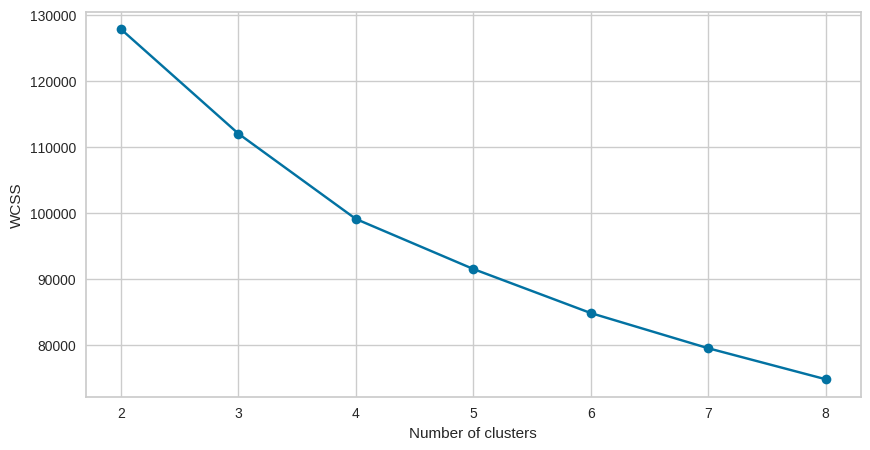

In [ ]:
#Other method for getting elbow
wcss = []
clusters = range(2, 9)
for k in clusters:
    kmc_elbow_2 = KMeans(n_clusters = k, init = 'k-means++', n_init = 10,
                         random_state = 42)
    kmc_elbow_2.fit(cc_df)
    wcss.append(kmc_elbow_2.inertia_)

fig = plt.subplots(figsize=(10, 5))
plt.plot((clusters), wcss, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [ ]:
# Using kneelocator to verify the elbow and find the optimal k
locate = KneeLocator(clusters, wcss, curve="convex", direction="decreasing")
print(f"The optimal number of clusters is: {locate.elbow}")

The optimal number of clusters is: 4


# Getting the Silhouette score

The silhouette score for 2 clusters is: 0.20954269658951744



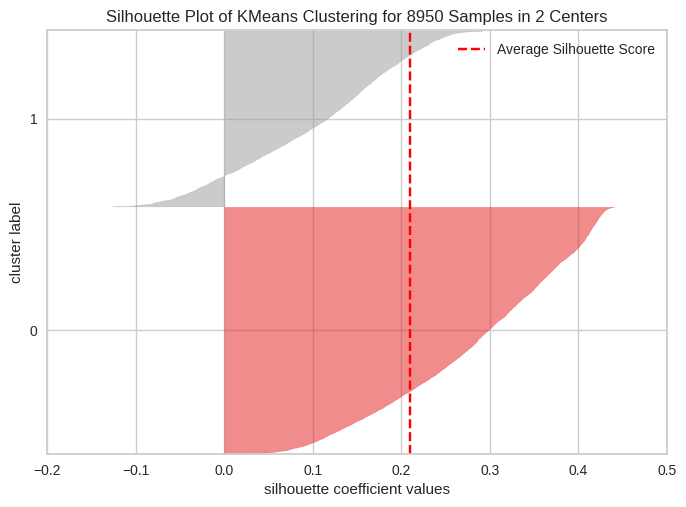

The silhouette score for 3 clusters is: 0.25070692042216985



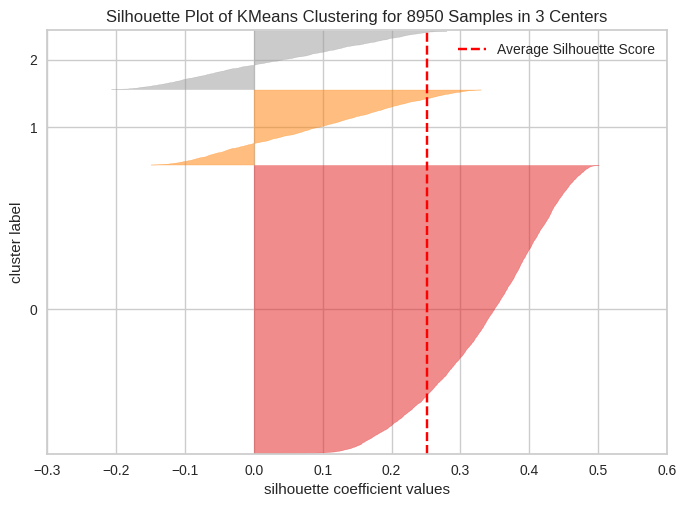

The silhouette score for 4 clusters is: 0.19767217227311326



The silhouette score for 5 clusters is: 0.19326461950272603



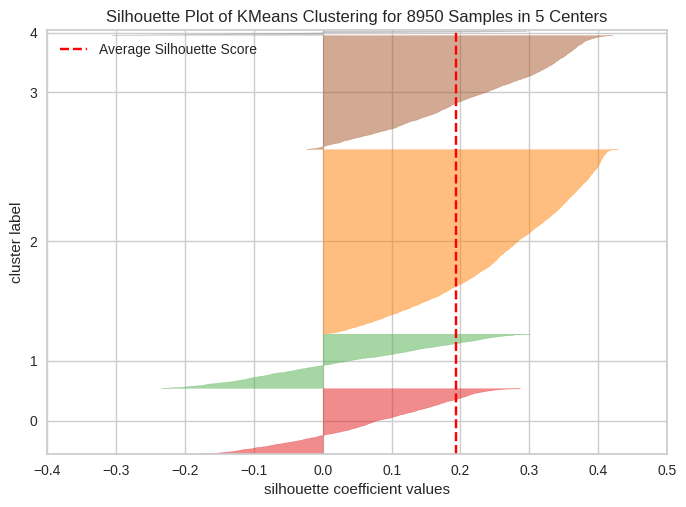

The silhouette score for 6 clusters is: 0.20277862200791616



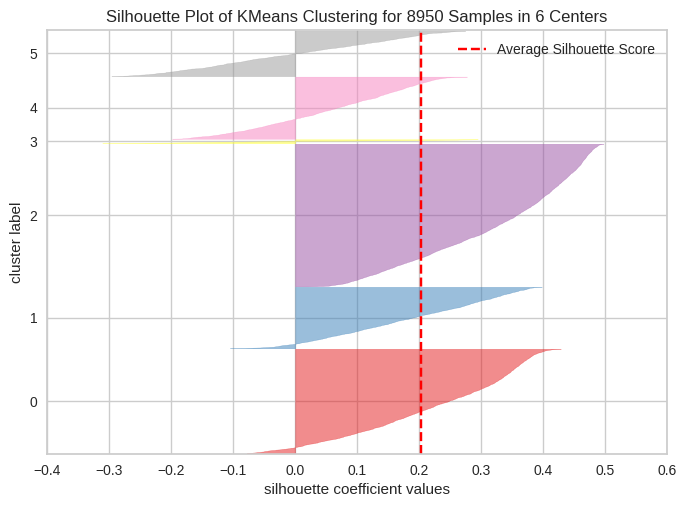

The silhouette score for 7 clusters is: 0.21470744987758258



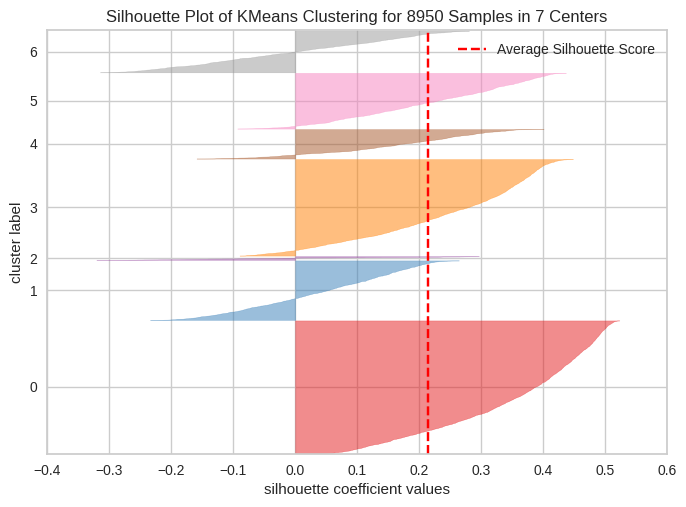

The silhouette score for 8 clusters is: 0.2187682621726236



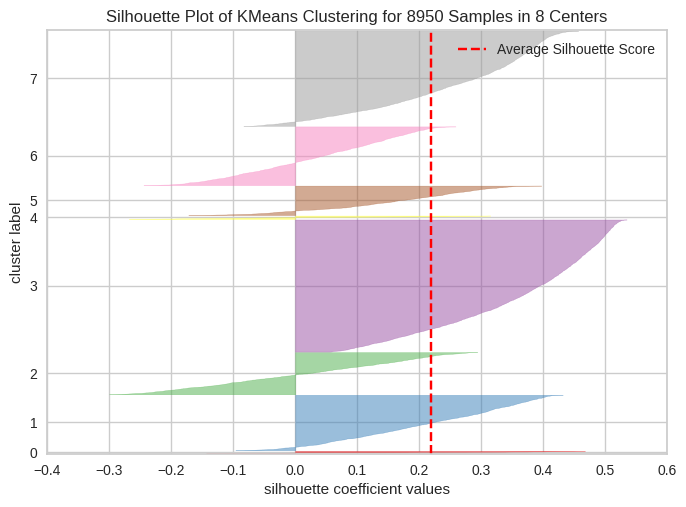

In [ ]:
'''
  Gets the silhouette score for every number of clusters.
  Does so for every number between 2 and 8
'''
silhouette_clusters = range(2, 9)
for cluster in silhouette_clusters:
  kmc_silhouette = KMeans(n_clusters = cluster, init = 'k-means++', random_state = 42)
  kmc_silhouette.fit(cc_df)
  score = silhouette_score(cc_df, kmc_silhouette.labels_)
  print(f"The silhouette score for {cluster} clusters is: {score}\n")
  visualizer_silhouette = SilhouetteVisualizer(kmc_silhouette)
  visualizer_silhouette.fit(cc_df)
  visualizer_silhouette.show()

In [ ]:
# Other simpler method for getting silhouette score:
silhouette_scores = []

for i in silhouette_clusters:
  kmc_silhouette_2 = KMeans(n_clusters = i, init = 'k-means++',
                            random_state = 42)
  kmc_silhouette_2.fit(cc_df)
  score = silhouette_score(cc_df, kmc_silhouette_2.labels_)
  silhouette_scores.append(score)
  print(f"The silhouette score for {i} clusters is {score}")

The silhouette score for 2 clusters is 0.20954269658951744
The silhouette score for 3 clusters is 0.25070692042216985
The silhouette score for 4 clusters is 0.19767217227311326
The silhouette score for 5 clusters is 0.19326461950272603
The silhouette score for 6 clusters is 0.20277862200791616
The silhouette score for 7 clusters is 0.21470744987758258
The silhouette score for 8 clusters is 0.2187682621726236


In [ ]:
# Plotting the silhouette scores relative to the number of clusters
plt.plot(silhouette_clusters, silhouette_scores)
plt.xticks(silhouette_clusters)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

# K-Means Clustering with 3 clusters (k result references silhouette score)

In [ ]:
cc_df.head()

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0 -0.731989          -0.249434  -0.424900         -0.356934   
1  0.786961           0.134325  -0.469552         -0.356934   
2  0.447135           0.518084  -0.107668          0.108889   
3  0.049099          -1.016953   0.232058          0.546189   
4 -0.358775           0.518084  -0.462063         -0.347294   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0               -0.349079     -0.466786            -0.806490   
1               -0.454576      2.605605            -1.221758   
2               -0.454576     -0.466786             1.269843   
3               -0.454576     -0.368653            -1.014125   
4               -0.454576     -0.466786            -1.014125   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                   -0.678661                         -0.707313   
1                   -0.678661                         -0.916995   
2                    2.673451                         -0.916995   
3                   -0.399319                         -0.916995   
4                   -0.399319                         -0.916995   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0               -0.675349         -0.476070      -0.511333     -0.960378   
1                0.573963          0.110074      -0.591796      0.688678   
2               -0.675349         -0.476070      -0.109020      0.826100   
3               -0.258913         -0.329534      -0.551565      0.826100   
4               -0.675349         -0.476070      -0.551565     -0.905410   

   PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT   TENURE  
0 -0.528979         -0.298429         -0.525551  0.36068  
1  0.818642          0.101044          0.234227  0.36068  
2 -0.383805         -0.089545         -0.525551  0.36068  
3 -0.598688         -0.358172         -0.525551  0.36068  
4 -0.364368         -0.253343         -0.525551  0.36068

In [ ]:
'''
  The standardized dataset will be converted into an array for
  the dataset to be readable by the visualization method later on.
  Three clusters were used, k-means++ speeds up the convergence, and
  a random state of 42 is used for replicability.
'''
array_dataset = np.asarray(cc_df)
kmeans = KMeans(n_clusters = 3, init= 'k-means++', random_state = 42)
kmc = kmeans.fit_predict(array_dataset)
cluster_labels = kmeans.labels_
clustered_cc = cc_df.copy()
clustered_cc['CLUSTER'] = cluster_labels
clustered_cc.head(6)

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0 -0.731989          -0.249434  -0.424900         -0.356934   
1  0.786961           0.134325  -0.469552         -0.356934   
2  0.447135           0.518084  -0.107668          0.108889   
3  0.049099          -1.016953   0.232058          0.546189   
4 -0.358775           0.518084  -0.462063         -0.347294   
5  0.117878           0.518084   0.154492         -0.356934   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0               -0.349079     -0.466786            -0.806490   
1               -0.454576      2.605605            -1.221758   
2               -0.454576     -0.466786             1.269843   
3               -0.454576     -0.368653            -1.014125   
4               -0.454576     -0.466786            -1.014125   
5                1.019822     -0.466786             0.439310   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                   -0.678661                         -0.707313   
1                   -0.678661                         -0.916995   
2                    2.673451                         -0.916995   
3                   -0.399319                         -0.916995   
4                   -0.399319                         -0.916995   
5                   -0.678661                          0.550784   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0               -0.675349         -0.476070      -0.511333     -0.960378   
1                0.573963          0.110074      -0.591796      0.688678   
2               -0.675349         -0.476070      -0.109020      0.826100   
3               -0.258913         -0.329534      -0.551565      0.826100   
4               -0.675349         -0.476070      -0.551565     -0.905410   
5               -0.675349         -0.476070      -0.269945     -0.740504   

   PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT   TENURE  CLUSTER  
0 -0.528979         -0.298429         -0.525551  0.36068        0  
1  0.818642          0.101044          0.234227  0.36068        1  
2 -0.383805         -0.089545         -0.525551  0.36068        0  
3 -0.598688         -0.358172         -0.525551  0.36068        0  
4 -0.364368         -0.253343         -0.525551  0.36068        0  
5 -0.115060          0.672701         -0.525551  0.36068        0

# Data Observation and Visualization

We may visualize the clustered data by picking columns to represent the x and y values for each cluster

In [ ]:
'''
 A simple way to visualize the datapoints by picking two columns/features to
 be counted as the x and y. The corresponding values will be plotted with sns.
'''

def plot_cluster(col1, col2):
  # Create colormap for the clusters
  colors = ['#640be0', '#a00ceb', '#0a4670', '#d0d411']

  sns.scatterplot(data = clustered_cc, x = col1, y = col2,
                  hue = cluster_labels, s = 20)

  plt.xlabel(col1)
  plt.ylabel(col2)
  plt.title(f'Clustered Data for {col1} and {col2}')
  plt.legend()
  plt.grid(True)
  plt.autoscale()  # Automatically adjust axis limits based on data
  plt.show()

plot_cluster('CREDIT_LIMIT', 'PURCHASES')

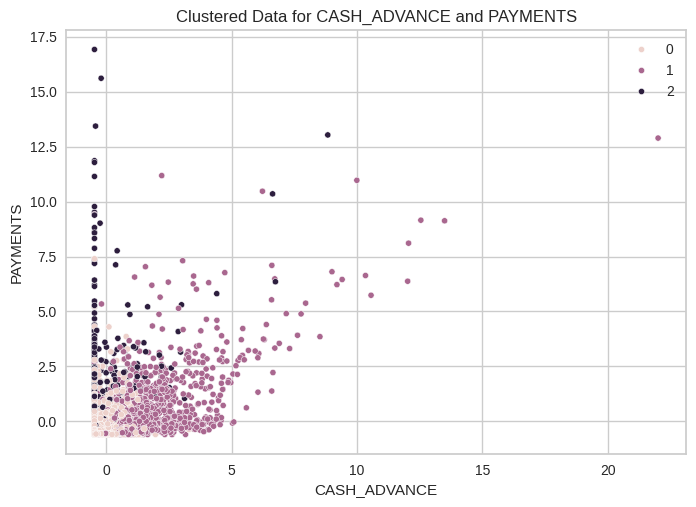

In [ ]:
plot_cluster('CASH_ADVANCE', 'PAYMENTS')

A 3-dimensional visualization is possible with the plotly library's graph_objects. The cluster's datapoints are represented by three chosen columns under the x, y, and z variables to represent the data point in the 3d space.

In [ ]:
'''
  Uses graph objects from plotly to plot 3 features instead.
  Utilizes Balance, Purchases, and Credit Limit as basis
  to plot the predicted clusters.
'''

cluster_plot = go.Figure()

cluster_colors = ['#640be0', 'yellow', '#0a4670', '#d0d411']

for cluster in list(clustered_cc['CLUSTER'].unique()):
  cluster_plot.add_trace(go.Scatter3d(
      x = clustered_cc[clustered_cc['CLUSTER'] == cluster]['BALANCE'],
      y = clustered_cc[clustered_cc['CLUSTER'] == cluster]['PURCHASES'],
      z = clustered_cc[clustered_cc['CLUSTER'] == cluster]['CREDIT_LIMIT'],
      mode = 'markers', marker_size = 4, marker_line_width = 1,
      name = str(i), marker = dict(color = cluster_colors[cluster])
  ))

cluster_plot.update_traces(hovertemplate='BALANCE: %{x} <br>PURCHASES: %{y} ' +
                           '<br>CREDIT_LIMIT: %{z}')

cluster_plot.update_layout(
    width = 800,
    height = 800,
    autosize = True,
    showlegend = True,
    scene = dict(
        xaxis = dict(title = 'BALANCE', titlefont_color = 'black'),
        yaxis = dict(title = 'PURCHASES', titlefont_color = 'black'),
        zaxis = dict(title = 'CREDIT_LIMIT', titlefont_color = 'black')
    ),
    font = dict(family = 'Gilroy', color = 'black', size = 12)
)

Another method is to use PCA to reduce the dimensionality of our dataset down to 2-dimensional and making the interpretation as well as visualizing easier.

In [ ]:
'''
 The PCA here uses an array version of the dataset to get the coordinates
 of each feature under the reduced dimension. 90% variance as n_components=0.90
 is a good metric because anything above 80% is generally accepted as great
'''
pca = PCA(n_components = 0.90, random_state = 42)

feature_2D = pca.fit_transform(array_dataset)
#feature_2D = pca.fit_transform(cc_df[spending_behavior])
kmeans_pca = KMeans(n_clusters = 4, init= 'k-means++', random_state = 42)
kmc_pca = kmeans_pca.fit_predict(feature_2D)
cluster_labels_pca = kmeans_pca.labels_

In [ ]:
''' colors used: #640be0 (purple), yellow,
     #0a4670 (dark turquoise), pink '''

def show_cluster():

    '''
    Section contains a list of colors mapped to each cluster.
    Kwargs/dictionaries properties for making the scatterplot
    This makes it so you don't have to specify it again as we
    call upon the various methods
    '''
    cluster_colors = ['#640be0', 'yellow', '#0a4670', 'pink']
    labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Centroids']
    #labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Centroids']
    title = dict(fontsize = 14, fontweight = 'bold', style = 'italic',
                 fontfamily = 'serif')
    scatter_style = dict(linewidth = 0.65, edgecolor = 'black', alpha = 0.85)
    legend_style = dict(borderpad = 2, frameon = False, fontsize = 8)

    # Creates an axis where the figure would lie
    fig, axis = plt.subplots(figsize=(12, 8))

    '''
    Section creates and defines the cluster scatterplot
    Each label is iterated through and plots their respective datapoints into
    the scatterplot (via their x and y coordinates).
    '''

    # Get all unique labels
    kmc_labels = list(set(cluster_labels_pca.tolist()))

    for label in kmc_labels:
        axis.scatter(feature_2D[kmc_pca == label, 0],
                     feature_2D[kmc_pca == label, 1],
                     s = 40, c = cluster_colors[label], **scatter_style)
    # end of for-loop


    #Gather the (x, y) coordinates of the centroids from the kmeans algorithm
    axis.scatter(kmeans_pca.cluster_centers_[:, 0], kmeans_pca.cluster_centers_[:, 1],
                 s = 65, c = '#a4034e', label ='Centroids', **scatter_style)

    # Turning off the spines or essentially the line marking data area boundary
    for spine in axis.spines.values():
        spine.set_color('None')
    # end of for-loop

    axis.set_title('Clusters', **title)
    axis.legend(labels, bbox_to_anchor = (0.95, -0.05), ncol = 5,
                **legend_style)
    axis.grid(axis = 'both', alpha = 0.5, color = '#9B9A9C',
              linestyle = 'dotted')

    axis.tick_params(right = False , labelleft = False ,
                     labelbottom = False)

    axis.spines['bottom'].set_visible(True)
    axis.spines['bottom'].set_color('#CAC9CD')

    plt.xlabel('Principal Component 1: Purchasing Habits')
    plt.ylabel('Principal Component 2: Cash Advance Reliance and Credit Card Repayments.')

    plt.show()

show_cluster()

#Conclusion:

The code plots PC1 on the x-axis and PC2 on the y-axis. Considering that the most influential features of PC1 are Purchases, Purchases Transactions, One-Off Purchases, Installments Purchases, and Purchases Frequency; to keep it short in our analysis, these features will be referred to as purchasing habits. On the other hand; Cash Advance, Cash Advance Frequency, Cash Advance Transactions, Balance, and Payments are the most influential features for PC2. These shall be simply referred to as cash advance reliance and credit card repayments.

Cluster 1 represents customers that have moderate to the highest reliance on Cash Advances or Credit Card Repayments among all customers in comparison to those from other clusters. These customers also are one of the least expensive on Purchasing Habits, in contrast. Cluster 2 (Yellow) can be compared as a direct inverse of the characteristics of Cluster 1 since customers from this cluster do not have high Cash Advance Reliance but have moderate to expensive Purchasing Habits. Cluster 3 (Dark Blue Green) represents customers that expend their financial resources the least among all customers due to not having expensive Purchase Habits and do not utilize Cash Advance Reliance and Credit card Repayments as much as customers from other clusters. Lastly, customers of Cluster 4 (Light Pink) have low Cash Advance Reliance and Credit card Repayments and are moderately expensive in Purchasing Habits. In summary, the clustering model was able to determine 4 different types of customers each having their unique characteristics differing on the extremeness of the features.


# Evaluation Metrics:

In [ ]:
'''
 Calculates the Explained Variance Ratio of each Principal Component
 including the total Explained Variance Ratio
'''
evr = pca.explained_variance_ratio_
for i in range(len(evr)):
  print(f"Explained Variance Ratio for PC{i+1}: {evr[i]}")
print(f"Total Explained Variance Ratio: {round(evr.sum(), 4)}")

Explained Variance Ratio for PC1: 0.273010422568215
Explained Variance Ratio for PC2: 0.20317046497314747
Explained Variance Ratio for PC3: 0.08822286403601874
Explained Variance Ratio for PC4: 0.07478018240103217
Explained Variance Ratio for PC5: 0.06212577343844275
Explained Variance Ratio for PC6: 0.05734208510052858
Explained Variance Ratio for PC7: 0.04881626798634487
Explained Variance Ratio for PC8: 0.04316476527743825
Explained Variance Ratio for PC9: 0.03786350551121629
Explained Variance Ratio for PC10: 0.030800284661931833
Total Explained Variance Ratio: 0.9193


# Metrics used to evaluate the clustering model:


*   **Davies-Bouldin Index:** ratio between the cluster scatter and the cluster's separation. The closer to 0 the better
*   **Silhouette Score:** quantifies how well a data point fits into its assigned cluster and how distinct it is from other clusters
*   **Calinski-Harabasz Index:** (Variance Ratio Criterion) ratio of the sum of between-clusters dispersion and of inter-cluster dispersion for all clusters. Higher score = better clustering performance






In [ ]:
# Calculates Davies-Bouldin Index, Silhouette Score, & Calinski-Harabasz Index
kmc_dbs = round(davies_bouldin_score(feature_2D, kmc_pca), 4)
kmc_sil_score = round(silhouette_score(feature_2D, kmc_pca), 4)
kmc_chs = round(calinski_harabasz_score(feature_2D, kmc_pca), 4)

print(f"Davies-Bouldin Score: {kmc_dbs}\n" +
      f"Silhouette Score: {kmc_sil_score}\n" +
      f"Calinski-Harabasz Score: {kmc_chs}")

Davies-Bouldin Score: 1.4794
Silhouette Score: 0.2169
Calinski-Harabasz Score: 1814.0367


# Profiling the clusters


In [ ]:
'''
 Provide clues about which features might be driving
 the separation between clusters using mean to describe the data
'''

# Adds a new column named "cluster_result" to the original credit card DataFrame
orig_ccdf['cluster_result'] = kmc_pca + 1 # Start with Cluster 1 instead
orig_ccdf['cluster_result'] = 'Cluster ' + orig_ccdf['cluster_result'].astype(str)

# Calculate overall mean of all features in original df (orig_ccdf)
ccdf_profile_overall = pd.DataFrame() #init empty df
ccdf_profile_overall['Overall'] = orig_ccdf.describe().loc[['mean']].T

# For each cluster, calculate and summarize the mean of each feature.
ccdf_cluster_summary = orig_ccdf.groupby('cluster_result').describe().T.reset_index().rename(columns={'level_0': 'Column Name', 'level_1': 'Metrics'})
ccdf_cluster_summary = ccdf_cluster_summary[ccdf_cluster_summary['Metrics'] == 'mean'].set_index('Column Name')

# Combines the summary of means df with overall mean of all features
ccdf_profile = ccdf_cluster_summary.join(ccdf_profile_overall).reset_index()
ccdf_profile.style.background_gradient(cmap='YlOrBr')

In [ ]:
'''
  A high absolute value (positive or negative) in a specific feature's loading
  indicates that the feature contributes significantly to the corresponding
  principal component.

  Wherein positive loading suggests that the feature value increases along with
  the direction of the principal component.
'''

# Gets top 5 most contributing features in PC1 via eigenvectors
eigenvectors = pca.components_
pc1_abs_values = np.abs(eigenvectors[0])
sorted_features_index = np.argsort(pc1_abs_values)[::-1]  # Descending order
top_5_features = sorted_features_index[:5]

for i, idx in enumerate(top_5_features):
  print(f"Top {i+1} Feature (PC1): Feature {idx+1} with contribution {pc1_abs_values[idx]}")

Top 1 Feature (PC1): Feature 3 with contribution 0.41152390638126063
Top 2 Feature (PC1): Feature 12 with contribution 0.39055576333886016
Top 3 Feature (PC1): Feature 4 with contribution 0.34629726166415853
Top 4 Feature (PC1): Feature 5 with contribution 0.3367376736461991
Top 5 Feature (PC1): Feature 7 with contribution 0.32113030965889305


If we were to reference the feature count with the index + 1 of the column headers in the credit card dataset, getting the top 5 most influential features in PC1 would be:


*   Purchases
*   Purchases_Trx
*   One-off_Purchase
*   Installments_Purchases
*   Purchases_Frequency






In [ ]:
# Gets top 3 most contributing features in PC2 via eigenvectors
eigenvectors = pca.components_
pc2_abs_values = np.abs(eigenvectors[1])
sorted_features_index2 = np.argsort(pc2_abs_values)[::-1]  # Descending order
top_5_features2 = sorted_features_index2[:5]

for i, idx in enumerate(top_5_features2):
  print(f"Top {i+1} Feature (PC2): Feature {idx+1} with contribution {pc2_abs_values[idx]}")

Top 1 Feature (PC2): Feature 6 with contribution 0.43897267369495624
Top 2 Feature (PC2): Feature 10 with contribution 0.4341726069202191
Top 3 Feature (PC2): Feature 11 with contribution 0.41964501028482104
Top 4 Feature (PC2): Feature 1 with contribution 0.4037503975321058
Top 5 Feature (PC2): Feature 14 with contribution 0.2564604666888972


If we were to reference the feature count with the index + 1 of the column headers in the credit card dataset, getting the top 5 most influential features in PC2 would be:


*   Cash_Advance
*   Cash_Advance_Frequency
*   Cash_Advance_Trx
*   Balance
*   Payments
